## 06. XGBoost(eXtra Gradient Boost)

- GBM 기반
- GBM의 단점인 느린 수행 시간 및 과적합 규제 부재 등의 문제를 해결

### XGBoost 장점
#### 1. 과적합 규제 
표준 GBM 내부에는 규제 기능이 없으나 XGBoost는 자체적으로 규제 기능을 가짐
#### 2. 나무가지치기 
일반적으로 GBM 분할 시 부정 손실이 발생하면 분할을 더 이상 수행 X, but 지나치게 많은 분할 발생 가능성 있음, XGBoost는 더 이상 긍정 이득이 없는 분할을 미리 제거하여 분할 수를 더 줄임
#### 3. 자체 내재된 교차 검증 
지정된 반복 횟수 X → 교차검증을 통해 평가 데이터 세트의 평가 값이 최적화되면 반복을 중단
#### 4. 결손값 자체 처리

#### 추가. 성능평가, 피처 중요도 시각화(plotting) 기능

In [1]:
# xgboost 설치
# ! conda install -c anaconda py-xgboost

In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings(action='ignore')

In [3]:
import xgboost as xgb
from xgboost import XGBClassifier

### 1. 파이썬 래퍼 XGBoost 하이퍼 파라미터
- 일반 파라미터 : 스레드 개수, slient 모드 등 선택을 위한 파라미터, 바뀌는 경우 거의 없음
- 부스터 파라미터 : 트리 최적화, 부스팅, regulation 등과 관련 파라미터
- 학습 태스크 파라미터 : 학습 수행 시 객체 함수, 평가를 위한 지표 등을 설정하는 파라미터

#### 일반 파라미터 
- `booster`(default=gbtree) : gbtree(tree based model) 또는 gblinear(linear model) 선택
- `slient`(default=0) : 출력 메시지를 나타내고 싶지 않을 경우 1
- `nthread`(default=전체 사용) : cpu 실행 스레드 개수 조정

#### 주요 부스터 파라미터
- `eta`(default=0.3) = learning_rate, (0~1), 
    - 파이썬 래퍼 기반 : default=0.3
    - 사이킷런 래퍼 클래스 : learning_rate, default=0.1
- `num_boost_rounds` = n_estimators
- `min_child_weight`(default=1) : 트리에 추가적으로 가지를 나눌지 결정하기 위해 필요한 데이터들의 weight 총합, 값이 작을수록 분할을 자제, 과적합 조절
- `gamma`(default=6) = max_depth : 0- 깊이에 제한을 없앰, 값이 높을수록 과적합 위험 ↑, 보통 3~10 사이의 값을 적용
- `sub_sample`(default=1) = subsample : 데이터 샘플링하는 비율, 보통 0.5~1 사이의 값을 적용
- `colsample_bytree`(default=1) = max_feature  : 트리 생성에 필요한 피처를 임의로 샘플링
- `lambda`(default=1) : L2 규제 적용값 (피처가 많을수록 적용하여 과적합 감소 시킴)
- `alpha`(default=0) : L1 규제 적용값 (피처가 많을수록 적용하여 과적합 감소 시킴)
- `scale_pos_weight`(default=1) : 비대칭한 클래스로 구성된 데이터 세트의 균형을 유지하기 위한 파라미터 *=stratified*

#### 학습 태스크 파라미터
- `objective`(default=reg:squarederror) :  손실함수 종류, 이진 분류/다중 분류에 따라 *종류가 엄청 많다.[링크](https://xgboost.readthedocs.io/en/latest/parameter.html#parameters-for-tweedie-regression-objective-reg-tweedie)*
    - `binary:logistic` : 이진 분류
    - `multi:softmax` : 다중 분류, 레이블 클래스의 개수인 num_class 파라미터 지정 필수
    - `multi:softprob` : 다중 분류, 레이블 클래스에 해당하는 예측 확률 반환
- `eval_metric`: 검증에 사용되는 함수를 정의 (defalt = rmse(회귀), error(분류))
    - rmse
    - mae
    - logloss : Negative log-likelihood
    - error : binary classification error 0.5 threshold
    - merror : multiclass classification error rate
    - mlogloss : multiclass logloss
    - auc

#### 과적합 제어
- eta(learning_rate) 낮추기 → 대신 num_rounds(n_estimators) 높이기
- max_depth 낮추기
- min_child_weight 높이기
- gamma 높이기
- subsample, colsample_bytree


### 2. 파이썬 래퍼 XGBoost 적용 - 위스콘신 유방암 예측

In [4]:
import xgboost # 파이썬 래퍼
print(xgboost.__version__)

1.3.3


In [5]:
import xgboost as xgb
from sklearn.datasets import load_breast_cancer

dataset = load_breast_cancer()
X_features = dataset.data
y_labels = dataset.target

cancer_df = pd.DataFrame(X_features, columns = dataset.feature_names)
cancer_df['target'] = y_labels
cancer_df

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0


#### 타겟 레이블 값의 분포
- 양성 = benign = 1 = 357개
- 악성 = malignant = 0 = 212개

In [6]:
print(dataset.target_names)
cancer_df['target'].value_counts()

['malignant' 'benign']


1    357
0    212
Name: target, dtype: int64

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train ,y_test = train_test_split(X_features, y_labels, 
                                                    test_size=0.2, random_state=156) # stratify=y_labels, 

print(X_train.shape, X_test.shape)

(455, 30) (114, 30)


#### DMatrix
- 학습용/테스트용 데이터 세트를 위해 필요한 객체
- 주요 인자 : 
    - data : 피처 데이터 세트 
    - label : 레이블 데이터 세트
   
- 사이킷런 XGBoost와의 차이점
- 판다스 DataFrame.values → ndarray → DMatrix

In [8]:
dtrain = xgb.DMatrix(data=X_train, label= y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

#### 하이퍼파라미터 설정
- 학습 수행 전 XGBoost의 하이퍼 파라미터 설정, 주로 딕셔너리 형태

####  train() 
- 사이킷런에서의 fit과 동일
- `early_stopping_rounds` : eval_set, eval_metric 지정 필수
    - eval_set : 성능 평가를 수행할 평가용 데이터 세트
    - eval_metric : 평가 세트에 적용할 성능 평가 방법 (분류일 경우 주로 'error'나 'logloss' 적용) 
- `evals` : 학습 데이터 세트와 검증 데이터 세트를 각각 'train'과 'eval'로 명기

In [9]:
params = {
    'max_depth':3,
    'eta':0.1,
    'objective':'binary:logistic',
    'eval_metric':'logloss',
    'early_stoppings':100
}
num_rounds = 400 

In [12]:
wlist = [(dtrain,'train'), (dtest, 'eval')]
xgb_model = xgb.train(params = params, dtrain=dtrain, num_boost_round = num_rounds,
                    early_stopping_rounds = num_rounds, evals=wlist)

[22:43:53] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { early_stoppings } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-logloss:0.60969	eval-logloss:0.61352
[1]	train-logloss:0.54080	eval-logloss:0.54784
[2]	train-logloss:0.48375	eval-logloss:0.49425
[3]	train-logloss:0.43446	eval-logloss:0.44799
[4]	train-logloss:0.39055	eval-logloss:0.40911
[5]	train-logloss:0.35414	eval-logloss:0.37498
[6]	train-logloss:0.32122	eval-logloss:0.34571
[7]	train-logloss:0.29259	eval-logloss:0.32053
[8]	train-logloss:0.26747	eval-logloss:0.29721
[9]	train-logloss:0.24515	eval-logloss:0.27799
[10]	train-logloss:0.22569	eval-logloss:0.26030
[11]	train-logloss:0.20794	eval-loglos

[161]	train-logloss:0.00726	eval-logloss:0.08801
[162]	train-logloss:0.00724	eval-logloss:0.08776
[163]	train-logloss:0.00722	eval-logloss:0.08778
[164]	train-logloss:0.00720	eval-logloss:0.08778
[165]	train-logloss:0.00718	eval-logloss:0.08752
[166]	train-logloss:0.00716	eval-logloss:0.08754
[167]	train-logloss:0.00714	eval-logloss:0.08764
[168]	train-logloss:0.00712	eval-logloss:0.08739
[169]	train-logloss:0.00710	eval-logloss:0.08738
[170]	train-logloss:0.00708	eval-logloss:0.08730
[171]	train-logloss:0.00707	eval-logloss:0.08737
[172]	train-logloss:0.00705	eval-logloss:0.08740
[173]	train-logloss:0.00703	eval-logloss:0.08739
[174]	train-logloss:0.00701	eval-logloss:0.08713
[175]	train-logloss:0.00699	eval-logloss:0.08716
[176]	train-logloss:0.00697	eval-logloss:0.08696
[177]	train-logloss:0.00696	eval-logloss:0.08705
[178]	train-logloss:0.00694	eval-logloss:0.08697
[179]	train-logloss:0.00692	eval-logloss:0.08697
[180]	train-logloss:0.00690	eval-logloss:0.08704
[181]	train-logloss:

[329]	train-logloss:0.00534	eval-logloss:0.08582
[330]	train-logloss:0.00533	eval-logloss:0.08587
[331]	train-logloss:0.00532	eval-logloss:0.08589
[332]	train-logloss:0.00532	eval-logloss:0.08592
[333]	train-logloss:0.00531	eval-logloss:0.08584
[334]	train-logloss:0.00531	eval-logloss:0.08574
[335]	train-logloss:0.00530	eval-logloss:0.08582
[336]	train-logloss:0.00529	eval-logloss:0.08589
[337]	train-logloss:0.00529	eval-logloss:0.08594
[338]	train-logloss:0.00528	eval-logloss:0.08583
[339]	train-logloss:0.00528	eval-logloss:0.08591
[340]	train-logloss:0.00527	eval-logloss:0.08583
[341]	train-logloss:0.00526	eval-logloss:0.08573
[342]	train-logloss:0.00526	eval-logloss:0.08568
[343]	train-logloss:0.00525	eval-logloss:0.08572
[344]	train-logloss:0.00525	eval-logloss:0.08580
[345]	train-logloss:0.00524	eval-logloss:0.08582
[346]	train-logloss:0.00524	eval-logloss:0.08571
[347]	train-logloss:0.00523	eval-logloss:0.08579
[348]	train-logloss:0.00523	eval-logloss:0.08583
[349]	train-logloss:

#### predict()
- 사이킷런에서 predict와 동일, but 파이썬 래퍼 predict는 0과1 예측 결과값이 아닌 예측 결과를 추정할 수 있는 확률 값을 반환

In [13]:
pred_probs = xgb_model.predict(dtest)
print(np.round(pred_probs[:10],3))

preds = [1 if x>0.5 else 0 for x in pred_probs]
print(preds[:10])

[0.95  0.003 0.9   0.086 0.993 1.    1.    0.999 0.998 0.   ]
[1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


In [18]:
# CH03.
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    cfs = confusion_matrix(y_test, pred)
    acc = accuracy_score(y_test, pred)
    prec = precision_score(y_test, pred)
    rcl = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    
    roc_auc = roc_auc_score(y_test, pred_proba)
    
    print("confusion matrix:")
    print(cfs)
    print("accuracy:{:.4f}, precision:{:.4f}, recall:{:.4f}, F1:{:.4f}, AUC:{:.4f} ".format(acc, prec, rcl, f1, roc_auc))


In [19]:
get_clf_eval(y_test, preds, pred_proba = pred_probs)

confusion matrix:
[[35  2]
 [ 1 76]]
accuracy:0.9737, precision:0.9744, recall:0.9870, F1:0.9806, AUC:0.9951 


#### plot_importance() 
- feature importance 시각화하는 함수


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

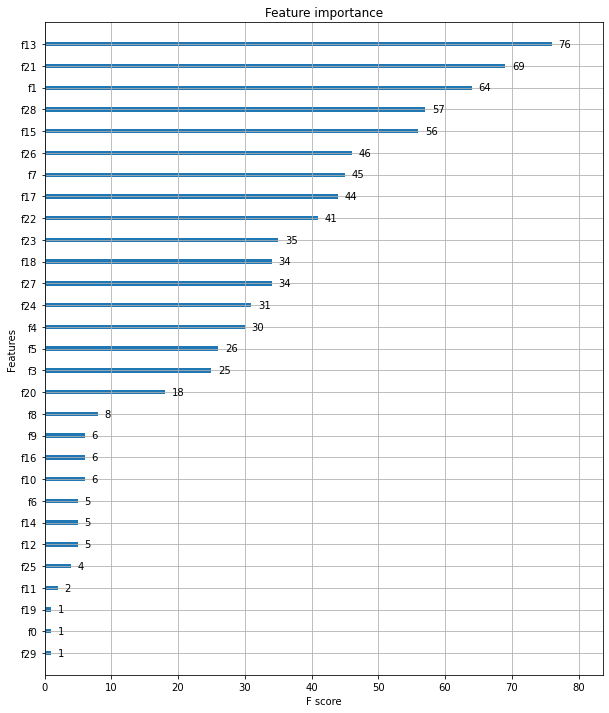

In [20]:
from xgboost import plot_importance

fig, ax = plt.subplots(figsize=(10,12))
plot_importance(xgb_model, ax=ax)

#### to_graphviz()
- 결정 트리 시각화

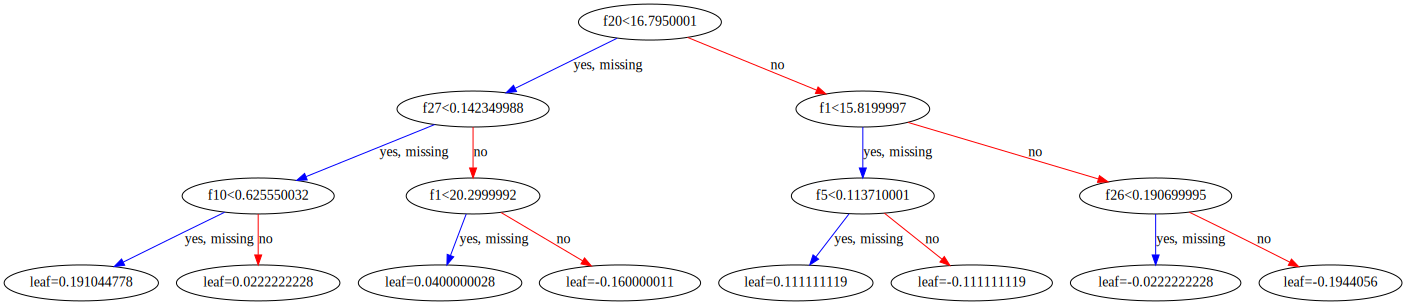

In [24]:
from xgboost import to_graphviz

to_graphviz(xgb_model)

#### cv()
- 사이킷런의 GridSearchCV와 유사, 교차 검증 수행 + 최적 파라미터 학습
```
xgboost.cv(params, dtrain, num_boost_round=10, nfold=3, stratified=False, folds=None, metrics=(), obj=None, feval=None, maximize=None, early_stopping_rounds=None, fpreproc=None, as_pandas=True, verbose_eval=None, show_stdv=True, seed=0, callbacks=None, shuffle=True)
```
- params (dict) : 부스터 파라미터
- dtrain : 학습 데이터
- num_boost_round : 부스팅 반복 횟수
- nfold = cv 폴드 개수
- stratified(bool) : cv 수행시 계층화 표본 추출 수행 여부
- metrics : cv 수행시 성능 평가 지표
- early_stopping_rounds : 조기 중단 활성화 반복 횟수 지정

### 3. 사이킷런 래퍼 XGBoost의 개요 및 적용
- eta → learning_rate
- sub_sample → subsample
- lambda → reg_lambda
- alpha → reg_alpha

In [29]:
from xgboost import XGBClassifier

xgb_sk = XGBClassifier(n_estimators=400, learning_rate = 0.1, max_depth=3)
xgb_sk.fit(X_train, y_train)
sk_preds = xgb_sk.predict(X_test)
sk_pred_proba = xgb_sk.predict_proba(X_test)[:,1]

get_clf_eval(y_test, sk_preds, sk_pred_proba)

# confusion matrix:
# [[35  2]
#  [ 1 76]]
# accuracy:0.9737, precision:0.9744, recall:0.9870, F1:0.9806, AUC:0.9951 

[23:14:02] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
confusion matrix:
[[35  2]
 [ 1 76]]
accuracy:0.9737, precision:0.9744, recall:0.9870, F1:0.9806, AUC:0.9951 


조기 중단 기능 추가하기

In [32]:
from xgboost import XGBClassifier

evals = [(X_test, y_test)]
xgb_sk = XGBClassifier(n_estimators=400, max_depth=3, learning_rate=0.1)
xgb_sk.fit(X_train, y_train, early_stopping_rounds = 100, eval_metric='logloss',
          eval_set = evals, verbose=True)

xgb_preds = xgb_sk.predict(X_test)

[0]	validation_0-logloss:0.61352
[1]	validation_0-logloss:0.54784
[2]	validation_0-logloss:0.49425
[3]	validation_0-logloss:0.44799
[4]	validation_0-logloss:0.40911
[5]	validation_0-logloss:0.37498
[6]	validation_0-logloss:0.34571
[7]	validation_0-logloss:0.32053
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.27799
[10]	validation_0-logloss:0.26030
[11]	validation_0-logloss:0.24604
[12]	validation_0-logloss:0.23156
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.20857
[15]	validation_0-logloss:0.19999
[16]	validation_0-logloss:0.19012
[17]	validation_0-logloss:0.18182
[18]	validation_0-logloss:0.17473
[19]	validation_0-logloss:0.16766
[20]	validation_0-logloss:0.15820
[21]	validation_0-logloss:0.15473
[22]	validation_0-logloss:0.14895
[23]	validation_0-logloss:0.14331
[24]	validation_0-logloss:0.13634
[25]	validation_0-logloss:0.13278
[26]	validation_0-logloss:0.12791
[27]	validation_0-logloss:0.12526
[28]	validation_0-logloss:0.11998
[29]	validation_0-loglos

[238]	validation_0-logloss:0.08639
[239]	validation_0-logloss:0.08634
[240]	validation_0-logloss:0.08618
[241]	validation_0-logloss:0.08619
[242]	validation_0-logloss:0.08625
[243]	validation_0-logloss:0.08626
[244]	validation_0-logloss:0.08629
[245]	validation_0-logloss:0.08622
[246]	validation_0-logloss:0.08640
[247]	validation_0-logloss:0.08635
[248]	validation_0-logloss:0.08628
[249]	validation_0-logloss:0.08645
[250]	validation_0-logloss:0.08629
[251]	validation_0-logloss:0.08631
[252]	validation_0-logloss:0.08636
[253]	validation_0-logloss:0.08639
[254]	validation_0-logloss:0.08649
[255]	validation_0-logloss:0.08644
[256]	validation_0-logloss:0.08629
[257]	validation_0-logloss:0.08646
[258]	validation_0-logloss:0.08639
[259]	validation_0-logloss:0.08644
[260]	validation_0-logloss:0.08646
[261]	validation_0-logloss:0.08649
[262]	validation_0-logloss:0.08644
[263]	validation_0-logloss:0.08647
[264]	validation_0-logloss:0.08632
[265]	validation_0-logloss:0.08649
[266]	validation_0-l

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=400, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [ ]:
get_clf_eval(y_test, pred)